## Mónica Villasuso López.
### Proyecto Individual - Datascience Bootcamp

## Clasificación de Lunares usando DATA AUGMENTATION

Ref https://enmilocalfunciona.io/tratamiento-de-imagenes-usando-imagedatagenerator-en-keras/
https://datasmarts.net/es/como-usar-imagedatagenerator-para-entrenar-una-cnn-en-keras/

Let your NN find it out for you. 

In [2]:
# Manejo de archivos y directorios
import os
from os import listdir
from os.path import isfile, join
#from utils.files import rename_filename, file_exists
# Librerías básicas (álgebra, números aleatorios, carga de datos en dataframe, visualizacion)
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle  
import csv
import random
from random import shuffle
# Para cargar  y mostrar imágenes
from PIL import Image
import imageio
import cv2
# Librerias para modelos de redes neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
# Para hacer data augmentacion
from tensorflow.keras.preprocessing.image import ImageDataGenerator   

from sklearn.metrics import confusion_matrix, classification_report  

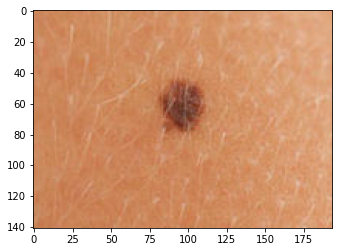

In [3]:
path_base = '/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/FinalIndiv_DataAug/'

image = Image.open(path_base + '/Lunares/train/benigno/b1.png')  
imgplot = plt.imshow(image)  
plt.show() 

In [4]:
class_names = ['benigno', 'maligno']

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.applications import densenet  
from tensorflow.keras.models import Sequential, Model, load_model  
from tensorflow.keras.layers import Conv2D, MaxPooling2D  
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from tensorflow.keras import regularizers  
from tensorflow.keras import backend as K  

In [10]:
K.set_learning_phase(1)

img_width, img_height = 48, 48  
nb_train_samples = 183  
nb_validation_samples = 47  
epochs = 10  
batch_size = 32  
n_classes = 2  

In [11]:
train_data_dir = path_base + '/Lunares/train'  
validation_data_dir = path_base + '/Lunares/test'

train_datagen = ImageDataGenerator(  
    rescale=1. / 255,
    zoom_range=0.2,
    rotation_range = 5,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 183 images belonging to 2 classes.
Found 47 images belonging to 2 classes.


In [15]:
def build_model():  
    base_model = densenet.DenseNet121(input_shape=(img_width, img_height, 3),
                                     weights= 'imagenet',
                                     include_top=False,
                                     pooling='avg')

    x = base_model.output
    x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [16]:
model = build_model()  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])  

29089792/29084464 [==============================] - 2s 0us/step


In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
callbacks_list = [early_stop, reduce_lr] 

In [19]:
model_history = model.fit(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks_list)

Epoch 1/10
6/6 [==============================] - 8s 1s/step - loss: 12.0917 - acc: 0.7869 - mse: 0.2383 - val_loss: 9.8527 - val_acc: 0.5000 - val_mse: 0.2410
Epoch 2/10
6/6 [==============================] - 8s 1s/step - loss: 8.6738 - acc: 0.7432 - mse: 0.2436 - val_loss: 7.3551 - val_acc: 0.4688 - val_mse: 0.2452
Epoch 3/10
6/6 [==============================] - 8s 1s/step - loss: 6.4199 - acc: 0.8087 - mse: 0.2457 - val_loss: 5.3509 - val_acc: 0.5000 - val_mse: 0.2482
Epoch 4/10
6/6 [==============================] - 8s 1s/step - loss: 4.9208 - acc: 0.7869 - mse: 0.2468 - val_loss: 4.3747 - val_acc: 0.5938 - val_mse: 0.2489
Epoch 5/10
6/6 [==============================] - 8s 1s/step - loss: 4.0027 - acc: 0.6831 - mse: 0.2476 - val_loss: 3.6405 - val_acc: 0.4688 - val_mse: 0.2500
Epoch 6/10
6/6 [==============================] - 8s 1s/step - loss: 3.4391 - acc: 0.7705 - mse: 0.2476 - val_loss: 3.2185 - val_acc: 0.5312 - val_mse: 0.2494
Epoch 7/10
6/6 [=============================

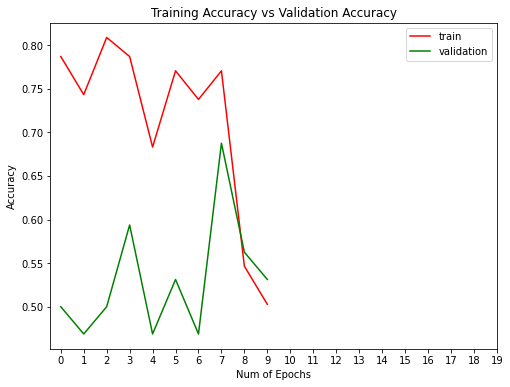

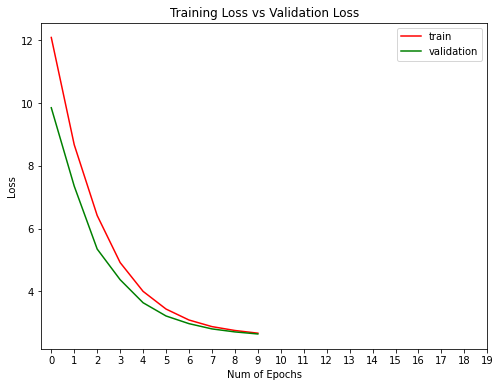

In [25]:
plt.figure(0)  
plt.plot(model_history.history['acc'],'r')  
plt.plot(model_history.history['val_acc'],'g')  
plt.xticks(np.arange(0, 20, 1.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(model_history.history['loss'],'r')  
plt.plot(model_history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 20, 1.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

""" plt.figure(2)  
plt.plot(model_history.history['mse'],'r')  
plt.plot(model_history.history['val_mean_squared_error'],'g')  
plt.xticks(np.arange(0, 20, 1.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("MSE")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation']) """

plt.show()  

In [26]:
model.evaluate_generator(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False)  

Instructions for updating:
Please use Model.evaluate, which supports generators.


[2.6453869342803955, 0.5106382966041565, 0.24873508512973785]

In [28]:
pred = model.predict(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)  
predicted = np.argmax(pred, axis=1)  

2/2 [==============================] - 0s 114ms/step


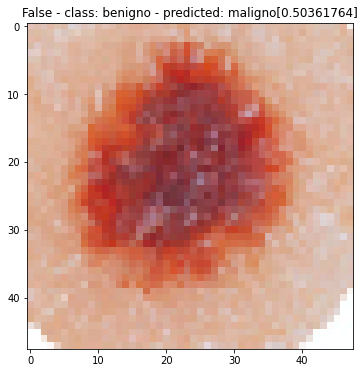

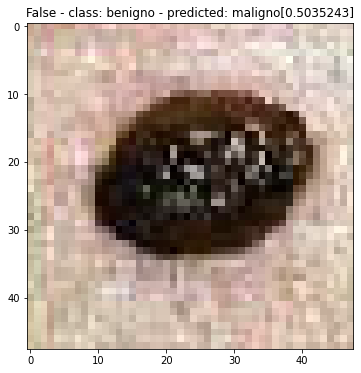

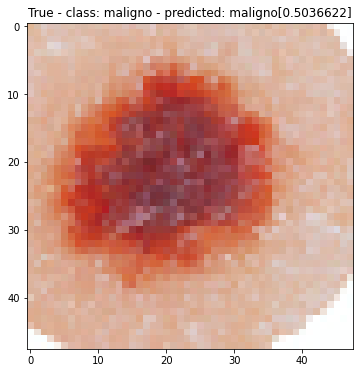

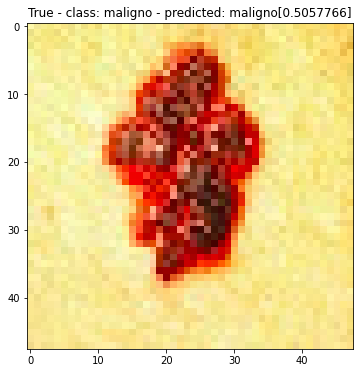

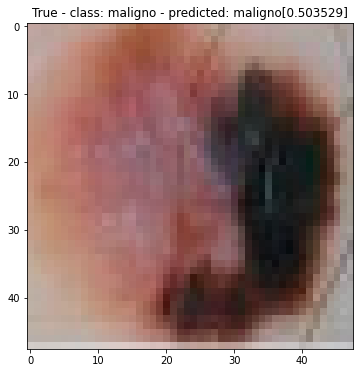

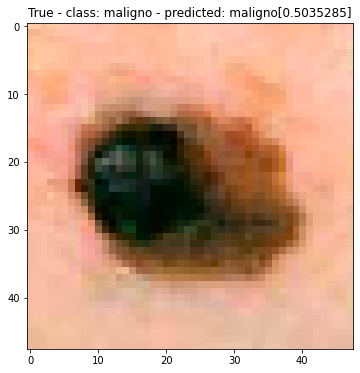

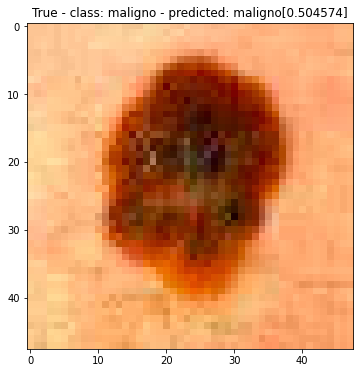

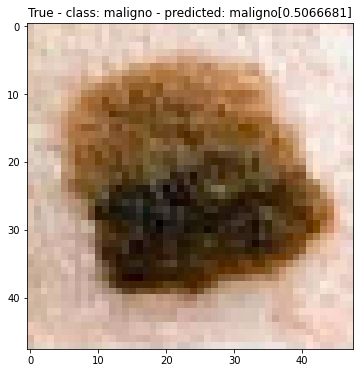

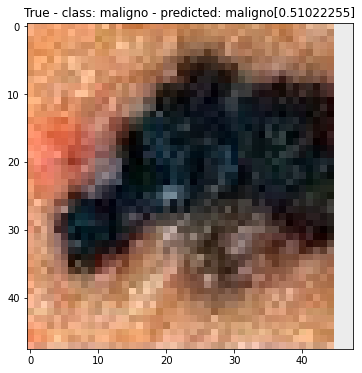

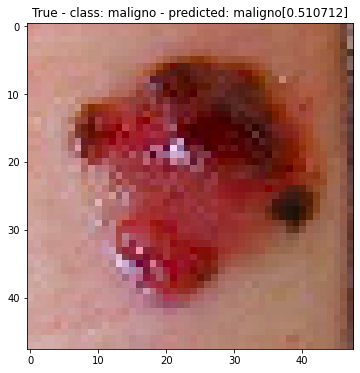

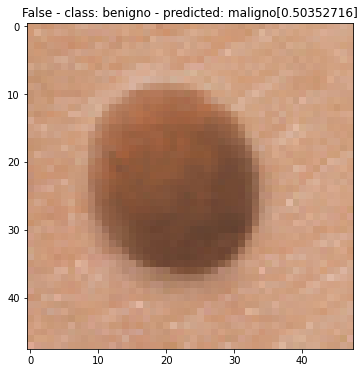

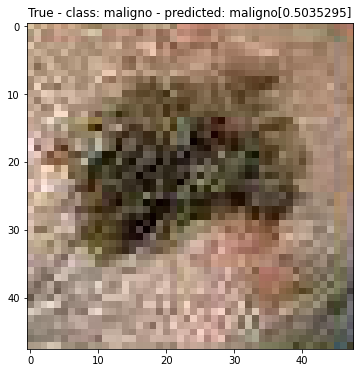

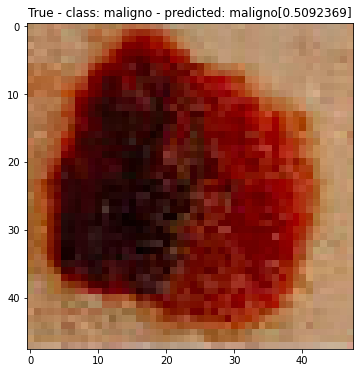

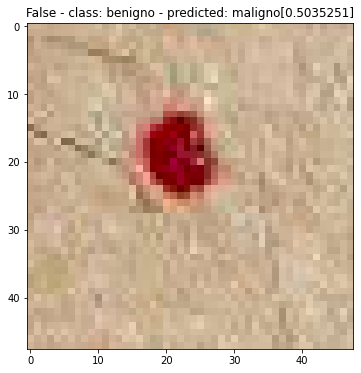

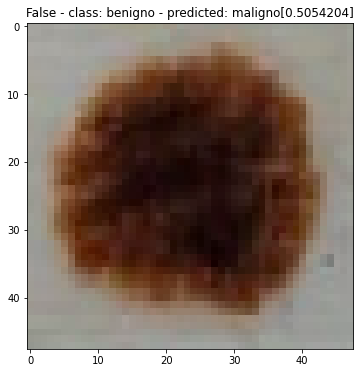

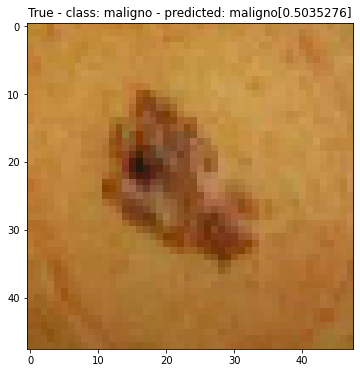

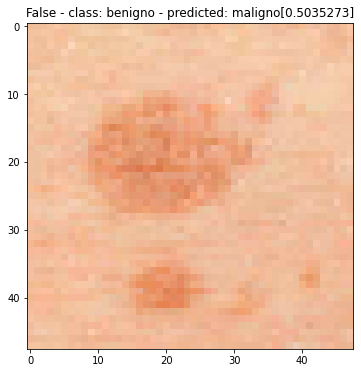

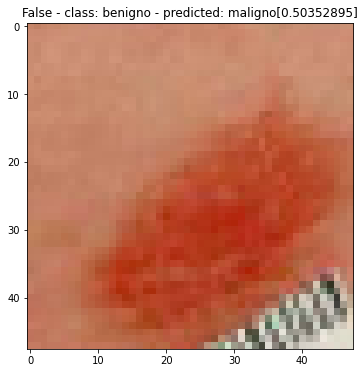

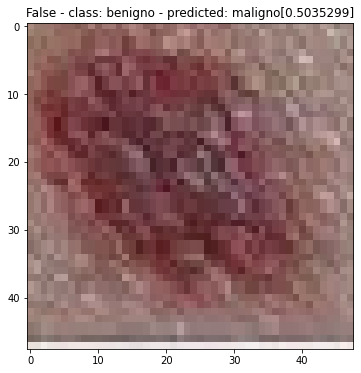

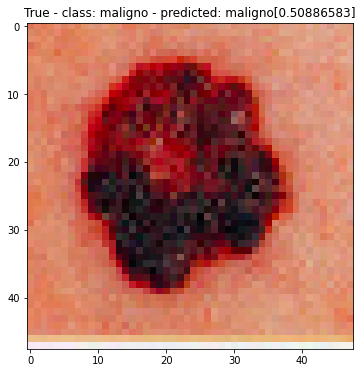

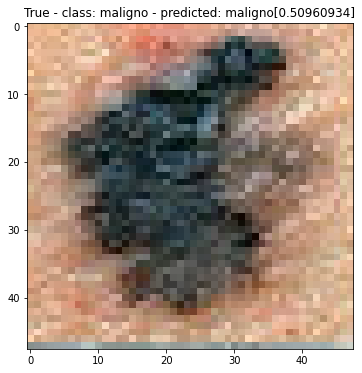

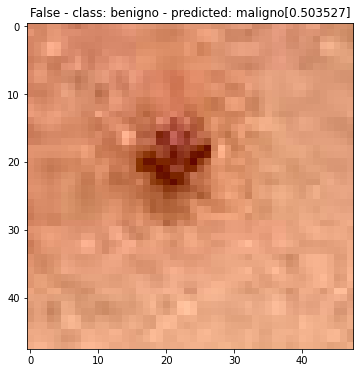

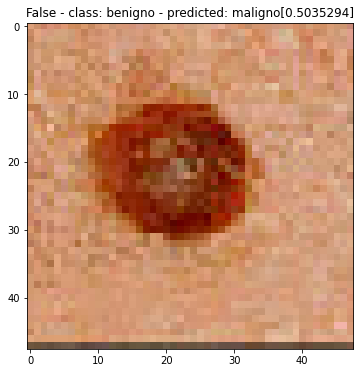

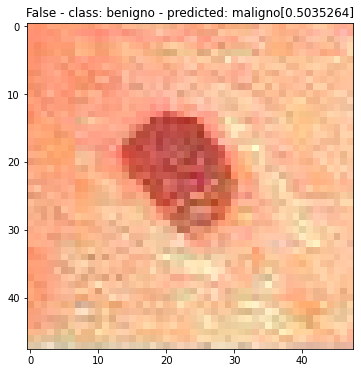

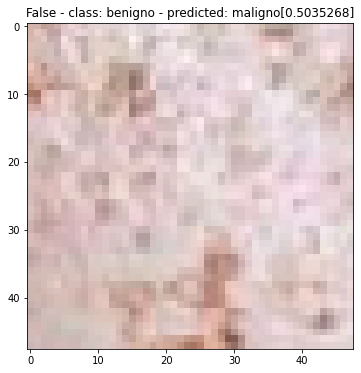

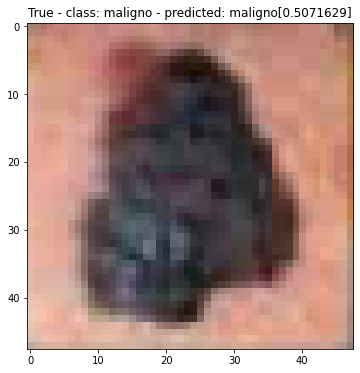

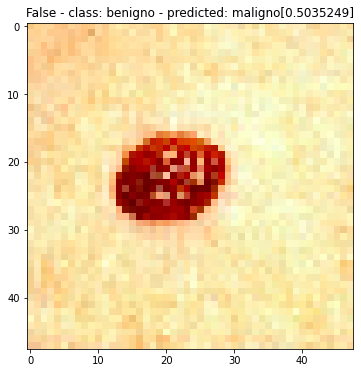

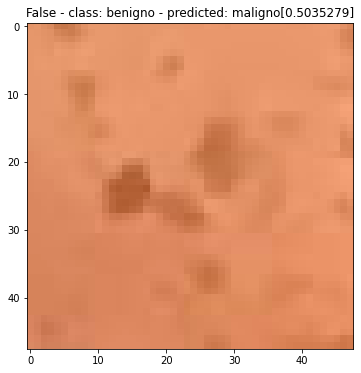

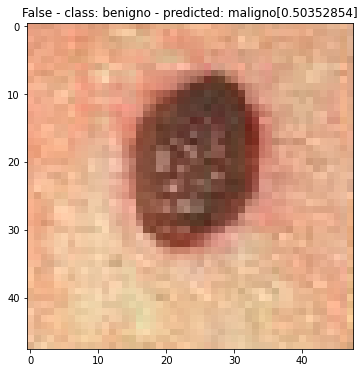

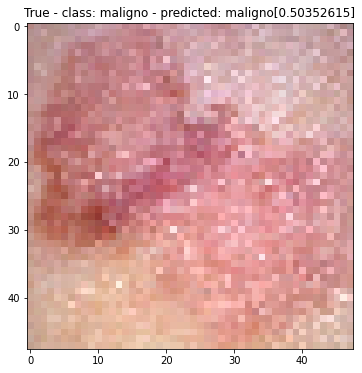

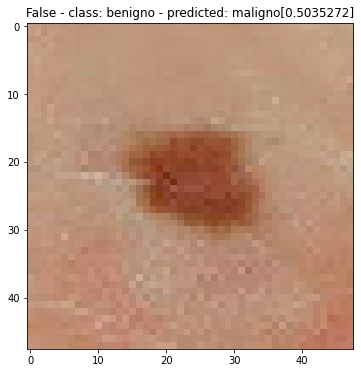

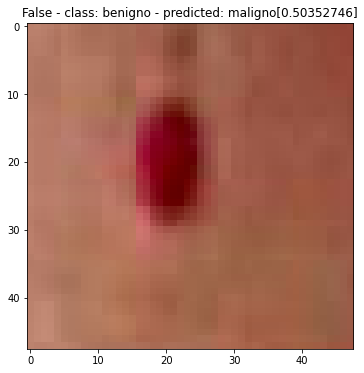

In [29]:
def predict_one(model):  
    image_batch, classes_batch = next(validation_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0]):
      image = image_batch[k]
      pred = predicted_batch[k]
      the_pred = np.argmax(pred)
      predicted = class_names[the_pred]
      val_pred = max(pred)
      the_class = np.argmax(classes_batch[k])
      value = class_names[np.argmax(classes_batch[k])]
      plt.figure(k)
      isTrue = (the_pred == the_class)
      plt.title(str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']')
      plt.imshow(image)

predict_one(model)  

### GUARDAR EL MODELO

In [119]:
os.chdir("/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/FinalIndiv/Lunares/modelos")

In [120]:
# Forma PRO de guardar los modelos  (en la carpeta modelos). Guarda el modelo y los pesos por separado. EL primer valor del nombre del archivo del modelo (test_acc)es el % de accuracy que alcanzó con el conjunto de test
import pickle
import json
import time
moment=time.localtime()
name='Model_{}_{}-{}-{}'.format(round(test_acc,5),moment[2],moment[3],moment[4])
model2.save(name)
model_json = model2.to_json()
with open(name+'.json', "w") as json_file:
    json.dump(model_json, json_file)
model2.save_weights(name+'.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model_0.82609_11-11-42/assets


In [353]:
def save_model(to_save, filepath):
    try:
        if file_exists(filepath=filepath):
            filepath = rename_filename(filepath=filepath)
        pickle.dump(to_save, open(filepath, 'wb'))
        print("Saved successfully")
        return True, filepath
    except Exception as e:
        print("Error during saving model:\n", e)
        return False, filepath

In [365]:
success, model_filename = save_model(to_save=model2, filepath="../../../../modelos/prueba_19.sav")

Error during saving model:
 cannot pickle '_thread.RLock' object


### CARGAR UN MODELO GUARDADO

In [ ]:
with open('prueba_6.sav', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

In [ ]:
model

### PRUEBA CON EL MODELO GUARDADO Y CARGADO

In [ ]:
model.fit (X,y)
y_pred = model.predict(X)
print(model,  " Score Test:", model.score(X,y)*100,"%", " RMSE:" , mean_squared_error(y, y_pred,squared=False))